# 0. Import Libraries

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage
import skimage.io

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

writer = SummaryWriter(logdir='runs/DCGAN_training_5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

1.2.0


In [47]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    # img = (img + 1) / 2
    img_numpy = img.numpy()
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

# GAN

# 1. Model Architecture

## 1-1. Generator

In [48]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf = 28, channels=1, bias = True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf, channels, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

## 1-2. Discriminator

In [49]:
class Discriminator(nn.Module):
    def __init__(self, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def discriminator_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *discriminator_block(channels, ndf, bn=False),
            *discriminator_block(ndf, ndf*2, bn=True),
            *discriminator_block(ndf*2, ndf*4, bn=True),
            *discriminator_block(ndf*4, ndf*8, bn=True)
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=bias),
            nn.Sigmoid()
        )

    def forward_features(self, x):
        features = self.features(x)
        return features

    def forward(self, x):
        features = self.forward_features(x)
        validity = self.last_layer(features)
        return validity

## 1-3. Encoder

In [50]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def encoder_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *encoder_block(channels, ndf, bn=False),
            *encoder_block(ndf, ndf*2, bn=True),
            *encoder_block(ndf*2, ndf*4, bn=True),
            *encoder_block(ndf*4, ndf*8, bn=True),
            nn.Conv2d(ndf*8, latent_dim, 4, 1, 0, bias=bias),
            nn.Tanh()
        )

    def forward(self, x):
        validity = self.features(x)
        return validity

# 2. Hyperparameters

In [51]:
n_epochs = 200
batch_size = 128
lr = 0.0002
ndf = 64
ngf = 64
latent_dim = 100
img_size = 64
channels = 3
n_critic = 5
split_rate = 1.0

# 3. Data Preprocessing

In [52]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = np.transpose(self.data[idx], (2, 0, 1))
        labels = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)


        return data, labels

## 3-2. Load Training Data

In [213]:
# Train Data
train_dataset = CIFAR10('./', train=True, download=True)

_x_train = torch.ByteTensor(train_dataset.data[torch.IntTensor(train_dataset.targets) == 8])
#_x_train = torch.ByteTensor(train_dataset.data)
#x_train = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

print(type(_x_train))

train_dataset_target = torch.Tensor(train_dataset.targets)
_y_train = train_dataset_target[train_dataset_target == 8]
#_y_train = train_dataset_target
#y_train = _y_train.split((int(len(_y_train) * split_rate)), dim=0)

train_mnist = SimpleDataset(_x_train, _y_train,
                                transform=transforms.Compose(
                                    [transforms.ToPILImage(),
                                     transforms.Resize(img_size),
                                     transforms.ToTensor()])
                                )
train_dataloader = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
<class 'torch.Tensor'>


In [217]:
print(_x_train[0].shape)

torch.Size([32, 32, 3])


In [80]:
#imshow_grid(next(iter(train_dataloader))[0])

# 4. DCGAN

## 4-1. optimizer

### 4-1-1. Weight Initialization

In [81]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [82]:
G = Generator(latent_dim = latent_dim, ngf=ngf, channels=channels, bias=False).to(device)
G.apply(weights_init)
D = Discriminator(ndf=ndf, channels=channels, bias=False).to(device)
D.apply(weights_init)

optimizer_G = optim.Adam(G.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))

## 4-2. DCGAN Training

### 4-2-1. Training

In [85]:
padding_epoch = len(str(n_epochs)) #3
padding_i = len(str(len(train_dataloader))) # 2

d_losses = []
g_losses = []

criterion = nn.BCELoss()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

        fake_imgs = G(z)

        real_validity = D(real_imgs)
        fake_validity = D(fake_imgs.detach())
        
        # Adversarial loss
        d_loss_real = criterion(real_validity, torch.ones_like(real_validity).to(device))
        d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity).to(device))
        d_loss = d_loss_real + d_loss_fake

        d_loss.backward()
        
        optimizer_D.step()
        
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            fake_imgs = G(z)
            fake_validity = D(fake_imgs)

            g_loss = criterion(fake_validity, torch.ones_like(fake_validity).to(device))

            g_loss.backward()
            optimizer_G.step()
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            writer.add_scalars('DCGAN loss', {'G_loss': g_loss.item(), 'D_loss': d_loss.item()}, epoch)
            
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():3f}] "
                f"[G loss: {g_loss.item():3f}]")
print('Finished Training')


[Epoch   0/200] [Batch  0/40] [D loss: 1.398021] [G loss: 5.694558]
[Epoch   0/200] [Batch  5/40] [D loss: 0.003911] [G loss: 11.331989]
[Epoch   0/200] [Batch 10/40] [D loss: 0.003335] [G loss: 6.885102]
[Epoch   0/200] [Batch 15/40] [D loss: 0.005626] [G loss: 13.836060]
[Epoch   0/200] [Batch 20/40] [D loss: 0.001277] [G loss: 8.788425]
[Epoch   0/200] [Batch 25/40] [D loss: 0.001888] [G loss: 11.064031]
[Epoch   0/200] [Batch 30/40] [D loss: 0.002036] [G loss: 7.513435]
[Epoch   0/200] [Batch 35/40] [D loss: 0.000223] [G loss: 18.675312]
[Epoch   1/200] [Batch  0/40] [D loss: 0.000138] [G loss: 13.864433]
[Epoch   1/200] [Batch  5/40] [D loss: 0.000882] [G loss: 8.235144]
[Epoch   1/200] [Batch 10/40] [D loss: 0.000102] [G loss: 19.796486]
[Epoch   1/200] [Batch 15/40] [D loss: 0.000117] [G loss: 10.427075]
[Epoch   1/200] [Batch 20/40] [D loss: 0.015538] [G loss: 31.186024]
[Epoch   1/200] [Batch 25/40] [D loss: 0.000051] [G loss: 30.141060]
[Epoch   1/200] [Batch 30/40] [D loss: 

### 4-2-2. Train Loss Plot

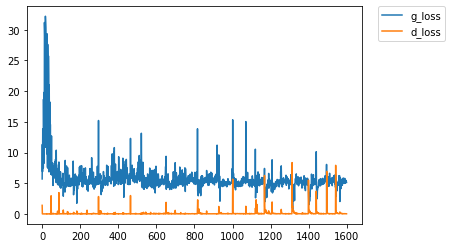

In [86]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4-2-3. Visualize Generated Fake Images

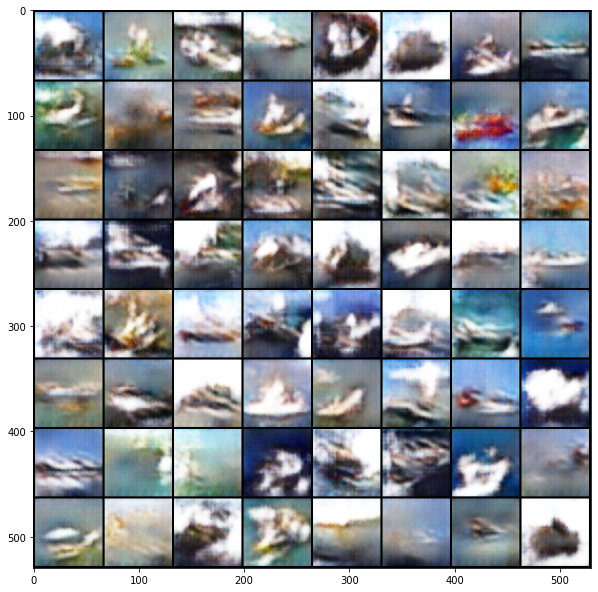

torch.Size([64, 3, 64, 64])


In [218]:
z = torch.randn(64, latent_dim, 1, 1).to(device)
imshow_grid(G(z))
print(G(z).shape)

# 5. Encoder

In [88]:
writer = SummaryWriter(logdir='runs/Encoder_training')

E = Encoder(latent_dim, ndf, channels, bias=False).to(device)
E.apply(weights_init)

G.eval()
D.eval()

criterion = nn.MSELoss()

optimizer_E = torch.optim.Adam(E.parameters(), lr=lr, betas=(0.0, 0.999))

padding_epoch = len(str(n_epochs))
padding_i = len(str(len(train_dataloader)))
kappa = 1.0
e_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        
        optimizer_E.zero_grad() 
        z = E(real_imgs)
        
        fake_imgs = G(z)

        real_features = D.forward_features(real_imgs)
        fake_features = D.forward_features(fake_imgs)

        # izif architecture
        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake_features, real_features)
        e_loss = loss_imgs + kappa * loss_features

        e_loss.backward()
        optimizer_E.step()


        if i % n_critic == 0:
            e_losses.append(e_loss)

            writer.add_scalar('e_loss', e_loss.item(), epoch)
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                    f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                    f"[E loss: {e_loss.item():3f}]")
            
#writer.close()
print('Finished Training')

[Epoch   0/200] [Batch  0/40] [E loss: 2.263326]
[Epoch   0/200] [Batch  5/40] [E loss: 0.771174]
[Epoch   0/200] [Batch 10/40] [E loss: 0.984688]
[Epoch   0/200] [Batch 15/40] [E loss: 0.603553]
[Epoch   0/200] [Batch 20/40] [E loss: 0.558707]
[Epoch   0/200] [Batch 25/40] [E loss: 0.589697]
[Epoch   0/200] [Batch 30/40] [E loss: 0.675328]
[Epoch   0/200] [Batch 35/40] [E loss: 0.558125]
[Epoch   1/200] [Batch  0/40] [E loss: 0.674614]
[Epoch   1/200] [Batch  5/40] [E loss: 0.559562]
[Epoch   1/200] [Batch 10/40] [E loss: 0.472035]
[Epoch   1/200] [Batch 15/40] [E loss: 0.537589]
[Epoch   1/200] [Batch 20/40] [E loss: 0.499444]
[Epoch   1/200] [Batch 25/40] [E loss: 0.689998]
[Epoch   1/200] [Batch 30/40] [E loss: 0.540825]
[Epoch   1/200] [Batch 35/40] [E loss: 0.501453]
[Epoch   2/200] [Batch  0/40] [E loss: 0.675259]
[Epoch   2/200] [Batch  5/40] [E loss: 0.537999]
[Epoch   2/200] [Batch 10/40] [E loss: 0.483509]
[Epoch   2/200] [Batch 15/40] [E loss: 0.458068]
[Epoch   2/200] [Bat

## 5-1. Visualize the Learned Inverse Mapping


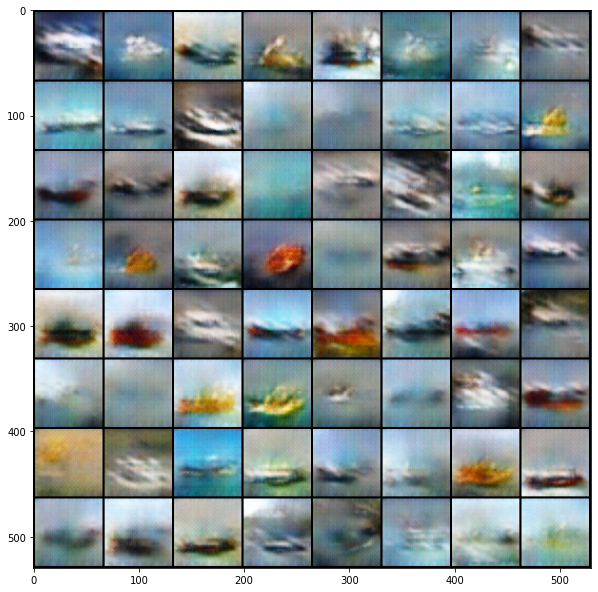

In [89]:
z = torch.randn(64, latent_dim, 1, 1).to(device) # 64, 100
fake_imgs = G(z) # 64, 1, 28, 28
fake_z = E(fake_imgs) #64, 100
reconfiguration_imgs = G(fake_z)

imshow_grid(reconfiguration_imgs)

# 6. Testing

## 6-1. Load Test Data

In [90]:
# Test DAta
test_dataset = CIFAR10('./', train=False, download=False)

#x_test = torch.cat([x_test_normal[:10], train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)[:20]
#y_test = torch.cat([y_test_normal[:10], train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)[:20]
#x_test = torch.cat([x_test_normal, torch.ByteTensor(train_dataset.data[torch.IntTensor(train_dataset.targets) != 1]), torch.ByteTensor(test_dataset.data)], dim=0)
#y_test = torch.cat([y_test_normal, train_dataset_target[train_dataset_target != 1], torch.FloatTensor(test_dataset.targets)], dim=0)

_x_test = torch.ByteTensor(test_dataset.data[torch.IntTensor(test_dataset.targets) == 8])
#_x_train = torch.ByteTensor(train_dataset.data)
#x_train = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

test_dataset_target = torch.Tensor(test_dataset.targets)
_y_test = test_dataset_target[test_dataset_target == 8]

test_mnist = SimpleDataset(_x_test, _y_test,
                            transform=transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.Resize(64),
                            transforms.ToTensor()])
                            )

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=True)

In [92]:
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = np.transpose(real_img.cpu().data.numpy().squeeze(), (1, 2, 0))
    real_img = real_img.reshape(64, 64, 3)
    generated_img = np.transpose(generated_img.cpu().data.numpy().squeeze(), (1, 2, 0))
    generated_img = generated_img.reshape(64, 64, 3)

    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    anomaly_img = [np.zeros(shape=(64, 64, 3)), np.zeros(shape=(64, 64, 3)), np.zeros(shape=(64, 64, 3))]
    anomaly_img[0] = (real_img - diff_img) * 255
    anomaly_img[1] = (real_img - diff_img) * 255
    anomaly_img[2] = (real_img - diff_img) * 255
    anomaly_img[0] = anomaly_img[0] + diff_img

    anomaly_img = [anomaly_img[0].astype(np.uint8), anomaly_img[1].astype(np.uint8), anomaly_img[2].astype(np.uint8)]

    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(20)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='bone', label='real')
    plots[1].imshow(generated_img, cmap='bone')
    plots[2].imshow(diff_img, cmap='bone')
    plots[3].imshow(anomaly_img[0], cmap='bone')

    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

In [329]:
criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

with open("score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
list2 = [x for x in range(0, 12288)]
masked_data = []
        
for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)
    real_img_copy = real_img.clone().detach()
    
    list3 = random.sample(list2, 12288//5)
    for k in list3:
        temp1 = random.uniform(0.0, 1.0)
        real_img[0][k%3][(k//3)//64][(k//3)%64] = temp1
        
    real_z = E(real_img)
    fake_img = G(real_z)
    fake_z = E(fake_img)

    #real_feature = D.forward_features(real_img) # 1, 256
    #fake_feature = D.forward_features(fake_img)

    #img_distance = criterion(fake_img, real_img)
    #loss_feature = criterion(fake_feature, real_feature)

    real_flat = torch.flatten(real_img[0].permute(1, 2, 0), start_dim=0, end_dim=-1).cpu().detach().numpy()
    fake_flat = torch.flatten(fake_img[0].permute(1, 2, 0), start_dim=0, end_dim=-1).cpu().detach().numpy()
    ground_truth_flat = torch.flatten(real_img_copy[0].permute(1, 2, 0), start_dim=0, end_dim=-1).cpu().detach().numpy()
    #print(real_img.shape)
    #print(xy.shape)
    
    
    diff_img = abs(real_flat - fake_flat)
    diff_img[diff_img > 0.25] = 2
    diff_img[diff_img <= 0.25] = 1
    real_diff_img = abs(real_flat - ground_truth_flat)
    real_diff_img[real_diff_img > 0.25] = 3
    real_diff_img[real_diff_img <= 0.25] = 5
    
    assess = abs(real_diff_img - diff_img)
    true_positive += (assess == 1.).sum()
    false_negative += (assess == 2.).sum()
    false_positive += (assess == 3.).sum()
    true_negative += (assess == 4.).sum()
    
    diff_img = abs(real_flat - fake_flat)
    diff_img[diff_img > 0.25] = 1
    diff_img[diff_img <= 0.25] = 0
    mask_ = abs(diff_img - 1)
    #print(type(mask_))
    denoised_img_ = real_flat * mask_
    #print(denoised_img.type)
    #denoised_img = denoised_img_.cpu().data.numpy() #* 255
    #print(real_flat.shape)
    masked_data.append((denoised_img_, mask_, ground_truth_flat, real_flat))

    
    
    #anomaly_score = img_distance + kappa*loss_feature

    #z_distance = criterion(fake_z, real_z)
    
    #with open("score.csv", "a") as f:
    #        f.write(f"{label.item()},{img_distance},"
    #                f"{anomaly_score},{z_distance}\n")
    """
    if i % 500 == 0:
        print(f"{label.item()}, {img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 0.3)
    """


In [330]:
accuracy = (true_positive.item() + true_negative.item())/(true_positive.item() + true_negative.item() + false_positive.item() + false_negative.item())
precision = true_positive.item() / (true_positive.item() + false_positive.item())
recall = true_positive.item() / (true_positive.item() + false_negative.item())
f1 = 2 * (precision * recall) / (precision + recall)
specificity = true_negative.item() / (false_positive.item() + true_negative.item())
print(accuracy, precision, recall, f1, specificity)

0.835646484375 0.3704599810787346 0.7561959540735952 0.49729527905969506 0.8452163427849159


# 7. GAIN

## 7-1. Import Libraries

In [96]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torch.nn.functional as F
import tensorflow as tf
old_v = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from input_data import read_data_sets
# from tensorflow.examples.tutorials.mnist import input_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 7-2. Initialize Parameters

In [97]:
use_gpu = True # set it to True to use GPU and False to use CPU
if use_gpu:
    torch.cuda.set_device(0)

In [98]:
# %% Initialize System Parameters
def init_params(mb_size=128, p_miss=0.2, p_hint=0.9, alpha=10, 
                Train_No=5000, Test_No=1000, 
                Dim=12288, H_Dim1=256, H_Dim2=128, 
                learning_rate=0.001, epochs=10000): 
    
    # Mini batch size
    mb_size = mb_size
    # Missing rate
    p_miss = p_miss
    # Hint rate
    p_hint = p_hint
    # Loss Hyperparameters
    alpha = alpha
    
    # No
    Train_No = Train_No
    Test_No = Test_No
    
    # Input dimension (Fixed)
    Dim = Dim
    # Hidden state dimensions
    H_Dim1 = H_Dim1
    H_Dim2 = H_Dim2
    
    # Learning Rate
    learning_rate = learning_rate
    # Epochs
    epochs = epochs
    
    return mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs

In [99]:
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params()

## 7-3. GAIN Model Architecture

In [ ]:
class NetD(torch.nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h):
        inp = torch.cat((x, h), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

    
class NetG(torch.nn.Module):
    def __init__(self):
        super(NetG, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m):
        inp = torch.cat((x, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))  # [0,1] Probability Output
        return out

## 7-4. Mask Vector and Hint Vector Generation

In [101]:
# Mask Vector and Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size=[m, n])
    B = A > p
    C = 1. * B
    return C


# Random sample generator for Z
def sample_Z(m, n, high):
    return np.random.uniform(0., high, size=[m, n])


# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

## 7-5. Define Loss Functions

In [102]:
def discriminator_loss(netG, netD, M, X, H): 
    # Generator
    G_sample = netG(X, M)
    # Combine with original data
    Hat_New_X = X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H)
    # Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss


def generator_loss(netG, netD, X, M, New_X, H):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H)

    # Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)
    G_loss = G_loss1 + alpha * MSE_train_loss 

    # MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss


def test_loss(netG, netD, X, M, New_X):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)

    # MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

In [103]:
# Plot (4 x 4 subfigures)
def plot(samples):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig


def outputFigure(it, netG, Test_No, mb_idx, Dim, high):
    mb_idx = sample_idx(Test_No, 5)
    X_mb = testX[mb_idx, :]
    M_mb = testM[mb_idx, :]
    Z_mb = sample_Z(5, Dim, high)

    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()
        Z_mb = torch.tensor(Z_mb).float()

    samples1 = X_mb
    samples5 = M_mb * X_mb + (1 - M_mb) * Z_mb
    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples2 = netG(inp, M_mb)
    samples2 = M_mb * X_mb + (1 - M_mb) * samples2

    Z_mb = sample_Z(5, Dim, high)
    if use_gpu is True:
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        Z_mb = torch.tensor(Z_mb).float()
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples3 = netG(inp, M_mb)
    samples3 = M_mb * X_mb + (1 - M_mb) * samples3

    Z_mb = sample_Z(5, Dim, high)
    if use_gpu is True:
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        Z_mb = torch.tensor(Z_mb).float()
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb
    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples4 = netG(inp, M_mb)
    samples4 = M_mb * X_mb + (1 - M_mb) * samples4

    if use_gpu is True:
        samples = np.vstack([samples5.cpu().detach().data, samples2.cpu().detach().data, 
                             samples3.cpu().detach().data, samples4.cpu().detach().data, 
                             samples1.cpu().detach().data])
    else:
        samples = np.vstack([samples5.detach().data, samples2.detach().data, 
                             samples3.detach().data, samples4.detach().data, 
                             samples1.detach().data])
    fig = plot(samples)
    plt.savefig('Multiple_Impute/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
    plt.close(fig)

## 7-6. GAIN Training and Testing Functions

In [300]:
def trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, 
              high=0.01, printLoss=True, outFigure=True):
    # %% Output Initialization
    if outFigure==True:    
        if not os.path.exists('Multiple_Impute/'):
            os.makedirs('Multiple_Impute/')
    
    # %% Start Iterations
    for it in tqdm(range(epochs)):
        # %% Inputs
        mb_idx = sample_idx(Train_No, mb_size) 
        X_mb = trainX[mb_idx,:]  
        Z_mb = sample_Z(mb_size, Dim, high) 

        M_mb = trainM[mb_idx, :]     
        H_mb1 = sample_M(mb_size, Dim, 1-p_hint) 
        H_mb = M_mb * H_mb1  
        # H_mb = M_mb * H_mb1 + 0.5 * (1 - H_mb1)

        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce 

        if use_gpu is True:
            X_mb = torch.tensor(X_mb, device='cuda').float()
            M_mb = torch.tensor(M_mb, device='cuda').float()
            H_mb = torch.tensor(H_mb, device='cuda').float()
            New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
            Z_mb = torch.tensor(Z_mb, device='cuda').float()
        else:
            X_mb = torch.tensor(X_mb).float()
            M_mb = torch.tensor(M_mb).float()
            H_mb = torch.tensor(H_mb).float()
            New_X_mb = torch.tensor(New_X_mb).float()
            Z_mb = torch.tensor(Z_mb).float()

        # Train Discriminator
        optimD.zero_grad() 
        D_loss = discriminator_loss(netG, netD, M=M_mb, X=New_X_mb, H=H_mb)
        D_loss.backward()
        optimD.step()

        # Train Generator
        optimG.zero_grad() 
        G_loss, G_mse_loss, G_mse_test = generator_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb)
        G_loss.backward()
        optimG.step()
       
        if it % 100 == 0:
            # %% Intermediate Losses
            if printLoss==True:
                print('Iter: {}'.format(it),end='\t')
                print('Train_loss: {:.4}'.format(G_mse_loss),end='\t')
                print('Test_loss: {:.4}'.format(G_mse_test),end='\t')
                print('D_loss: {:.4}'.format(D_loss))
            
            # %% Output figure
            #if outFigure==True:
                #outputFigure(it, netG, Test_No, mb_idx, Dim, high) 
            

def testGAIN(netG, netD, Dim, testM, testX, high=0.01):
    Z_mb = sample_Z(Test_No, Dim, high) 
    M_mb = testM 
    X_mb = testX
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  

    # make the tensors
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()

    MSE_final, Sample = test_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb)
    #print('Test RMSE: ' + str(np.sqrt(MSE_final.item())))
    print()
    
    return Sample, New_X_mb

In [105]:
def plotBeforeAfter(New_X_mb, imputed_x, plot_name1, plot_name2):
    if not os.path.exists('images/'):
        os.makedirs('images/')
    
    # Plot images before Imputation
    fig, axes = plt.subplots(10,10, figsize=(8,8))
    for i,ax in enumerate(axes.flat):
        if use_gpu is True:
            ax.imshow(New_X_mb[i].cpu().reshape(28,28))
        else:
            ax.imshow(New_X_mb[i].reshape(28,28))
    fig.savefig('images/' + plot_name1)
    
    # Plot images after Imputation
    fig, axes = plt.subplots(10,10, figsize=(8,8))
    for i,ax in enumerate(axes.flat):
        if use_gpu is True:
            ax.imshow(imputed_x[i].cpu().detach().numpy().reshape(28,28))
        else:
            ax.imshow(imputed_x[i].detach().numpy().reshape(28,28))
    fig.savefig('images/' + plot_name2)

## 7-7. Load Corrupt Test Data and Dirty Vectors

In [331]:
#print(masked_data[0][0].reshape(784))
testX = []
testM = []
clean_testX = []
corrupted_testX = []
for i in range(len(masked_data)):
    testX.append(masked_data[i][0])
    testM.append(masked_data[i][1])
    clean_testX.append(masked_data[i][2])
    corrupted_testX.append(masked_data[i][3])

In [332]:
testX = np.array(testX)
testM = np.array(testM)

## 7-8. Load Training Data and Generate Training Mask Vector

In [108]:
trainX = []

#aa = train_mnist[0][0].permute(1, 2, 0)
#rint(aa.shape)
#torch.flatten(aa, start_dim=0, end_dim=-1).detach().numpy().shape
for data in train_mnist:
    trainX.append(torch.flatten(data[0].permute(1, 2, 0), start_dim=0, end_dim=-1).detach().numpy())

trainX = np.array(trainX)

#for data in test_mnist:
#    testX.append(torch.flatten(data[0].permute(1, 2, 0), start_dim=0, end_dim=-1).detach().numpy())

In [109]:
print(trainX.shape)

(5000, 12288)


In [110]:
#trainX = np.array(trainX)
#testX = np.array(testX)

# Train / Test Missing Indicators
trainM = sample_M(len(trainX), Dim, p_miss)

## 7-9. Train GAIN

In [112]:
if use_gpu is True:
    netD = NetD().cuda()
    netG = NetG().cuda()
else:
    netD = NetD()
    netG = NetG()

# Optimizers
optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate)
optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate)

In [113]:
trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, high=1.)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iter: 0	Train_loss: 0.06247	Test_loss: 0.06257	D_loss: 0.6941
Iter: 100	Train_loss: 0.02422	Test_loss: 0.02424	D_loss: 0.5011
Iter: 200	Train_loss: 0.01885	Test_loss: 0.01894	D_loss: 0.501
Iter: 300	Train_loss: 0.01609	Test_loss: 0.01628	D_loss: 0.5008
Iter: 400	Train_loss: 0.01334	Test_loss: 0.01349	D_loss: 0.5004
Iter: 500	Train_loss: 0.0128	Test_loss: 0.01303	D_loss: 0.5005
Iter: 600	Train_loss: 0.01317	Test_loss: 0.01334	D_loss: 0.5004
Iter: 700	Train_loss: 0.01168	Test_loss: 0.01184	D_loss: 0.5016
Iter: 800	Train_loss: 0.0118	Test_loss: 0.01202	D_loss: 0.5009
Iter: 900	Train_loss: 0.01195	Test_loss: 0.01232	D_loss: 0.5004
Iter: 1000	Train_loss: 0.01098	Test_loss: 0.0113	D_loss: 0.5
Iter: 1100	Train_loss: 0.01068	Test_loss: 0.01096	D_loss: 0.4998
Iter: 1200	Train_loss: 0.01008	Test_loss: 0.01052	D_loss: 0.5003
Iter: 1300	Train_loss: 0.01005	Test_loss: 0.01035	D_loss: 0.4995
Iter: 1400	Train_loss: 0.009413	Test_loss: 0.009743	D_loss: 0.4999
Iter: 1500	Train_loss: 0.009707	Test_loss:

## 7-10. Test GAIN with Corrupt Data

In [334]:
# %% Testing
imputed_x, New_X_mb = testGAIN(netG, netD, Dim, testM, testX, high=1.)
dif = abs(imputed_x.cpu().data.numpy() - clean_testX)
rmse_imputed = np.sum(np.sqrt(np.sum(np.square(dif), axis=1)/12288))/1000
std_imputed = np.std(np.sqrt(np.sum(np.square(dif), axis=1)/12288))
dif_2 = abs(np.array(corrupted_testX) - clean_testX)
rmse_dirty = np.sum(np.sqrt(np.sum(np.square(dif_2), axis=1)/12288))/1000
std_corrupted = np.std(np.sqrt(np.sum(np.square(dif_2), axis=1)/12288))

print("Corrected RMSE: ", rmse_imputed, "Corrected STD: ", std_imputed)
print("Corrupted RMSE: ", rmse_dirty, "Corrected STD: ", std_corrupted)

print("Imputed Data Shape:", imputed_x.shape)


Corrected RMSE:  0.12558890533447264 Corrected STD:  0.045054182
Corrupted RMSE:  0.16801148986816405 Corrected STD:  0.016278593
Imputed Data Shape: torch.Size([1000, 12288])
